# Laboratorio #1 – Detección de Pishing

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import log2
from urllib.parse import urlparse, unquote
import re

## Parte 1 – Ingeniería de características

### Exploración de datos

In [93]:
dataset = pd.read_csv('dataset_pishing.csv')

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     11430 non-null  object
 1   status  11430 non-null  object
dtypes: object(2)
memory usage: 178.7+ KB


In [25]:
dataset.url.value_counts()

url
http://e710z0ear.du.r.appspot.com/c:/users/user/downlo                                                                                                                                                                                                                                                                                                                                                                                                                                           2
http://www.crestonwood.com/router.php                                                                                                                                                                                                                                                                                                                                                                                                                                                            1
https://www.riverbed.com/produ

In [4]:
dataset.head()

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [10]:
dataset.status.value_counts()

status
legitimate    5715
phishing      5715
Name: count, dtype: int64

¿Está balanceado el dataset?

Sí, se puede observar en la celda anterior que el dataset por coincidencia tiene la misma cantidad de etiquetas _legitimate_ y _pishing_. Algor curioso, y que de inicio no representaría problema para el modelo. Aunque quizas puede llegar a afectarlo en algún momento aunque el sobreajuste o sesgo no sea el problema.

### Derivación de características

#### ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?

Aunque parece una mejor forma ya que se tendrían más datos relacionados al sitio que se visita, esto implica la extracción de datos "extras". Pues esos datos, obviamente, no se pueden obtener del URL. Haciendo que el tiempo de procesamiento (para URLs nuevas) sea mucho más tardado al depender de terceros para obtener esa información. Haciendo que la ventaja principal sea la autonomía del programa con un único dato, el cuál es el URL. Además, que la velocidad en la que se procesan los features será muy rápida para cualquier ML que se desee implementar.

#### ¿Qué características de una URL son más prometedoras para la detección de phishing?

En los artículos se mencionaron muchos features los cuales al aparecer cierta cantidad de veces en el URL podrían llegar a indicar algo. Gracias a esas features el modelo era capaz de detectar un URL de pishing y uno legítimo, sin entrar a detalle a la página. Por ello los features del URL que escogimos fueron:
- Dominio
- Formato IP dominio
- Tamaño
- URL acortado (TinyURL)
- Email dentro de él
- URL dentro del URL
- Presencia de palabras clave
- Número de: 
    - Vocales dentro del dominio
    - Puntos "."
    - Guiones "-"
    - Guiones bajos "_"
    - Slash "/"
    - Doble slash "//"
    - Arrobas "@"
    - Porcentaje "%"

Además de las 15 features descritas anteriormente, también se agregará la entropía de Shanon y relativa del URL.


### Preprocesamiento

In [94]:
dataset.status = dataset.status.map({'phishing': 1, 'legitimate': 0})

In [27]:
dataset

,url,status
0,http://www.crestonwood.com/router.php,0
1,http://shadetreetechnology.com/V4/validation/a...,1
2,https://support-appleld.com.secureupdate.duila...,1
3,http://rgipt.ac.in,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0
...,...,...
11425,http://www.fontspace.com/category/blackletter,0
11426,http://www.budgetbots.com/server.php/Server%20...,1
11427,https://www.facebook.com/Interactive-Televisio...,0
11428,http://www.mypublicdomainpictures.com/,0


In [95]:
dataset.drop_duplicates(subset=['url'], keep='last', inplace=True)

In [56]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11429 entries, 0 to 11429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     11429 non-null  object
 1   status  11429 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 267.9+ KB


In [39]:
dataset

,url,status
0,http://www.crestonwood.com/router.php,0
1,http://shadetreetechnology.com/V4/validation/a...,1
2,https://support-appleld.com.secureupdate.duila...,1
3,http://rgipt.ac.in,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0
...,...,...
11425,http://www.fontspace.com/category/blackletter,0
11426,http://www.budgetbots.com/server.php/Server%20...,1
11427,https://www.facebook.com/Interactive-Televisio...,0
11428,http://www.mypublicdomainpictures.com/,0


### Selección de características

#### ¿Qué columnas o características fueron seleccionadas y por qué?

Las características seleccionadas se mencionaron en la pregunta anterior. Pero aquí se detalla el porqué fueron seleccionadas.

- Dominio: El dominio es esencial conocerlo, ya que puede suponer cierta validez para un URL.
- Formato IP dominio: Un formato en IP de un dominio implicaría una alta probabilidad que el URL sea de phishing, ya que ninguna página oficial mostaría un URL de esa forma (sin dominio).
- Tamaño: El tamaño del URL es fundamental. Pues al ser uno de un tamaño muy grande podría ser una gran alerta a que se trata de una URL falsa.
- URL acortado (TinyURL): Un URL acortado oculta el verdadero URL, por lo que debería de ser tomado como algo alarmante y no confiar en ningún URL que venga en esta presentación.
- Email dentro de él: Al igual que un formato IP, un email dentro del url podría implicar dos cosas: si va como parámetro, es raro ya que si de seguridad de habla eso no sería muy adecuado. Otra parte es que esté en el url en el dominio o el path, lo cuál implicaría una entrada a un servidor seguramente de un tercero, algo que no es oficial o verificado.
- URL dentro del URL: Seguramente se trata de un url malintencionado, ya que intenta redireccionar al usuario a otro sitio sin que éste lo sepa.
- Presencia de palabras clave: Los atacantes suelen poner palabras los cuales hacen pensar al usuario que es imperativo que ingrese al URL, haciendole creer que es legítimo y que debe de acceder lo antes posible para no caer en alguna "pérdida". Aunque la lista de palabras es arbitraría, podría mejorarse.
- Número de: 
    - Vocales dentro del dominio: Regularmente los dominios tienen una cantidad de vocales aceptable, pero si es algo generado automáticamente (como sería en muchos phishing) este constará de consonantes lo cuál sería raro ya que no expresa sentido.
    - Puntos ".": Los puntos delimitan el url en varios aspectos. Como subdominios dentro del url. Por lo que una alta cantidad de éstos podría indicar un phishing.
    - Guiones "-": La presencia de estos símbolos son regularmente para intentar simular que el url es uno legítimo.
    - Guiones bajos "_": Igual que el guión normal "-", se utilizan para darle "legitimidad" a los url y el usuario se sienta "seguro" que no es phishing. Aunque su presencia dentro del dominio no es del todo cotidiano o normal.
    - Slash "/": El slash indica un viaje dentro del directorio, una alta cantidad de estos podría ser peligroso y tratarse del phishing al adentrarse tanto en un directorio.
    - Doble slash "//": El doble slash indica un redireccionamiento, si existe una alta cantidad de estos en un url puede indicar un phishing seguro.
    - Arrobas "@": Los arrobas (parecidos al doble slash //) pueden ocasionar que el navegador ignore la parte izquierda del url haciendolos pasar como links legítimos. O bien, realizar un login a un dominio.
    - Porcentaje "%": El símbolo de porcentaje se utiliza dentro de un url para varias cosas. Entre ellas es la codificacion de ciertos símbolos, un %20 sería un espacio " ". Dado que esto "oculta" para un usuario común, la alta cantidad de este símbolo podría indicar un phishing.

In [99]:
probabilities = {
    '-': 0.013342298553905901,
    '_': 9.04562613824129e-06,
    '0': 0.0024875471880163543,
    '1': 0.004884638114650296,
    '2': 0.004373560237839663,
    '3': 0.0021136613076357144,
    '4': 0.001625197496170685,
    '5': 0.0013070929769758662,
    '6': 0.0014880054997406921,
    '7': 0.001471421851820583,
    '8': 0.0012663876593537805,
    '9': 0.0010327089841158806,
    'a': 0.07333590631143488,
    'b': 0.04293204925644953,
    'c': 0.027385633133525503,
    'd': 0.02769469202658208,
    'e': 0.07086192756262588,
    'f': 0.01249653250998034,
    'g': 0.038516276096631406,
    'h': 0.024017645001386995,
    'i': 0.060447396668797414,
    'j': 0.007082725266242929,
    'k': 0.01659570875496002,
    'l': 0.05815885325582237,
    'm': 0.033884915513851865,
    'n': 0.04753175014774523,
    'o': 0.09413783122067709,
    'p': 0.042555148167356144,
    'q': 0.0017231917793349655,
    'r': 0.06460084667060655,
    's': 0.07214640647425614,
    't': 0.06447722311338391,
    'u': 0.034792493336388744,
    'v': 0.011637198026847418,
    'w': 0.013318176884203925,
    'x': 0.003170491961453572,
    'y': 0.016381628936354975,
    'z': 0.004715786426736459
}

def getFrecuency(word):
    frequency = {}
    for letter in word:
        frequency[letter] = frequency.get(letter, 0) + 1
    return frequency, sum(frequency.values())

def shannonEntropy(word):
    frequency, total = getFrecuency(word)
    return sum(freq / total * log2(total / freq) for freq in frequency.values())

def relativeEntropy(word):
    frequency, total = getFrecuency(word)
    return sum(freq / total * log2((freq / total) / (probabilities.get(key, 0.00001))) for key, freq in frequency.items())

def addFeatures(df):
    features = []
    
    for url in df['url']:
        domain = urlparse(url).netloc
        if re.match(r"^www.",domain):
	        domain = domain.replace("www.", "")
        
        ipFormat = 1 if bool(re.match(r'^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$', domain)) else 0
        
        size = len(url)
        
        shortened = 1 if any(service in url.lower() for service in ['bit.ly', 'tinyurl', 't.co', 'goo.gl', 'tiny.cc', 'ow.ly', 'is.gd', 'buff.ly', 'adf.ly', 'bitly']) else 0
        
        email = re.findall(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', url)
        hasEmail = 1 if bool(email) else 0

        urlInUrl = 0
        decodedUrl = unquote(url)
        urls = re.findall(r"https?://(?:[a-zA-Z0-9\-._~:/?#\[\]@!$&'()*+,;=%])+", decodedUrl)
        if len(urls) > 1 or (urls and urls[0] != url):
            urlInUrl = 1

        keyWord = 1 if any(keyword in url.lower() for keyword in ['confirm', 'account', 'banking', 'secure', 'login', 'signin']) else 0
        
        vowelsCount = len(re.findall(r'[aeiou]', domain, re.IGNORECASE))
        dotsCount = url.count('.')
        hyphenCount = url.count('-')
        underscoreCount = url.count('_')
        slashCount = url.count('/')
        doubleSlashCount = url.count('//')
        atCount = url.count('@')
        percentCount = url.count('%')
        
        shannonEntropyValue = shannonEntropy(url)
        relativeEntropyValue = relativeEntropy(url)
        
        features.append({
            'domain': domain,
            'ipFormat': ipFormat,
            'size': size,
            'shortened': shortened,
            'hasEmail': hasEmail,
            'urlInUrl': urlInUrl,
            'keyWord': keyWord,
            'vowelsCount': vowelsCount,
            'dotsCount': dotsCount,
            'hyphenCount': hyphenCount,
            'underscoreCount': underscoreCount,
            'slashCount': slashCount,
            'doubleSlashCount': doubleSlashCount,
            'atCount': atCount,
            'percentCount': percentCount,
            'shannonEntropy': shannonEntropyValue,
            'relativeEntropy': relativeEntropyValue
        })
    
    featuresDf = pd.DataFrame(features, index=df.index)

    return pd.concat([df, featuresDf], axis=1)

In [100]:
finalDf = addFeatures(dataset)

In [101]:
finalDf

,url,status,domain,ipFormat,size,shortened,hasEmail,urlInUrl,keyWord,vowelsCount,dotsCount,hyphenCount,underscoreCount,slashCount,doubleSlashCount,atCount,percentCount,shannonEntropy,relativeEntropy
0,http://www.crestonwood.com/router.php,0,crestonwood.com,0,37,0,0,0,0,5,3,0,0,3,1,0,0,3.787043,3.008741
1,http://shadetreetechnology.com/V4/validation/a...,1,shadetreetechnology.com,0,77,0,0,0,0,8,1,0,0,5,1,0,0,4.419864,2.111752
2,https://support-appleld.com.secureupdate.duila...,1,support-appleld.com.secureupdate.duilawyeryork...,0,126,0,0,0,1,17,4,1,2,5,1,0,0,4.753412,2.136120
3,http://rgipt.ac.in,0,rgipt.ac.in,0,18,0,0,0,0,3,2,0,0,2,1,0,0,3.461320,4.288902
4,http://www.iracing.com/tracks/gateway-motorspo...,0,iracing.com,0,55,0,0,0,0,4,2,2,0,5,1,0,0,4.097662,2.183324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,0,fontspace.com,0,45,0,0,0,0,4,2,0,0,4,1,0,0,4.119088,2.266273
11426,http://www.budgetbots.com/server.php/Server%20...,1,budgetbots.com,0,84,0,1,1,0,4,5,0,0,5,1,1,1,4.938590,3.439451
11427,https://www.facebook.com/Interactive-Televisio...,0,facebook.com,0,105,0,0,0,0,5,2,6,1,5,1,0,0,4.987577,2.130537
11428,http://www.mypublicdomainpictures.com/,0,mypublicdomainpictures.com,0,38,0,0,0,0,9,2,0,0,3,1,0,0,4.214132,2.301963


## Parte 2 - Implementación

### EDA

In [103]:
columnasNumericas = finalDf.select_dtypes(include=[np.number]).columns
columnasNoNumericas = finalDf.select_dtypes(exclude=[np.number]).columns

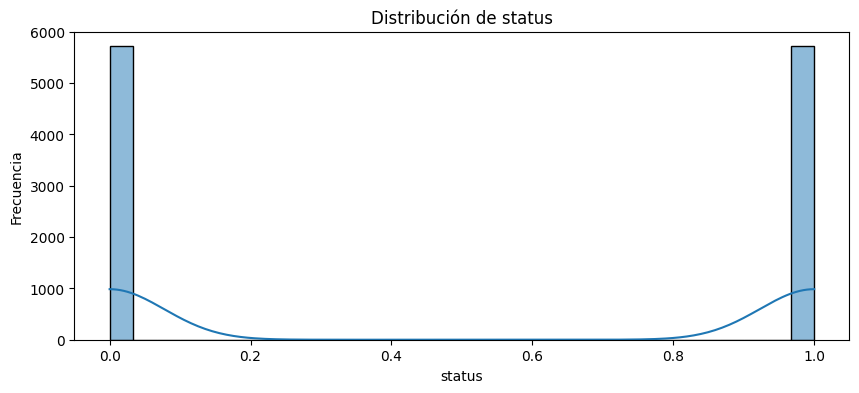

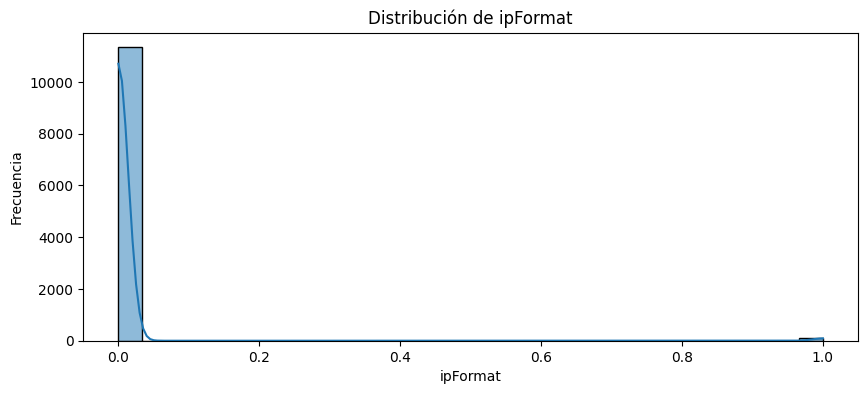

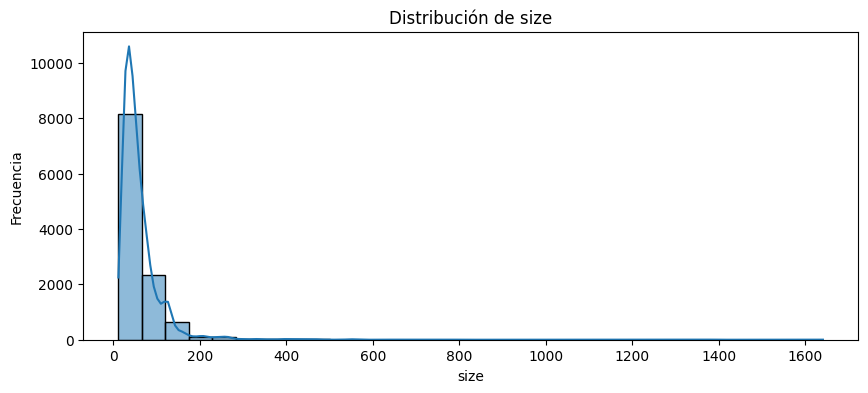

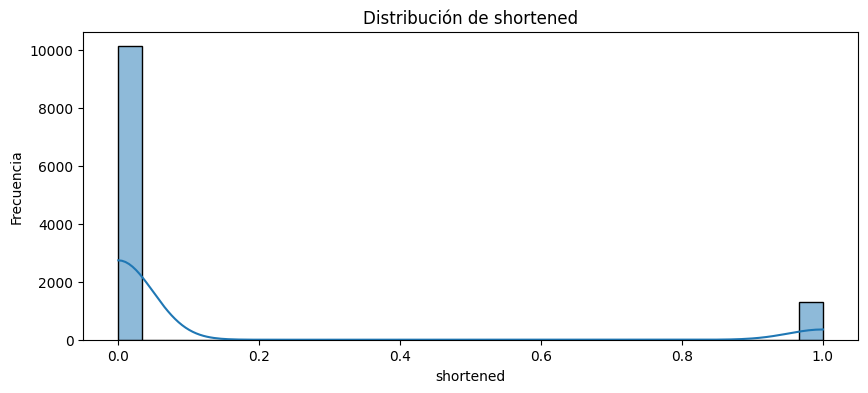

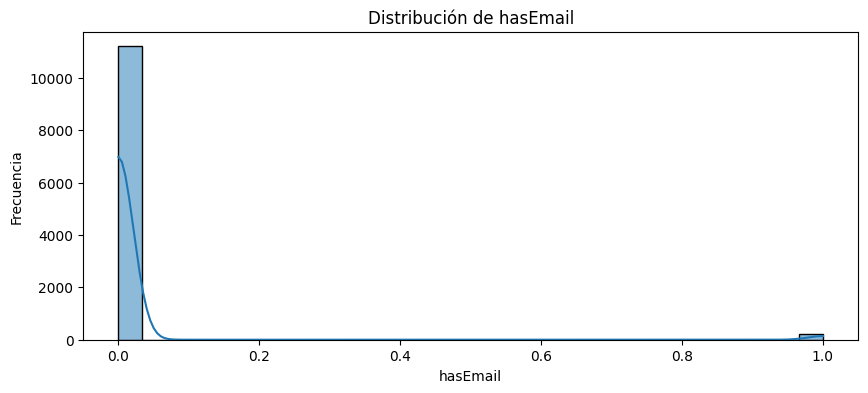

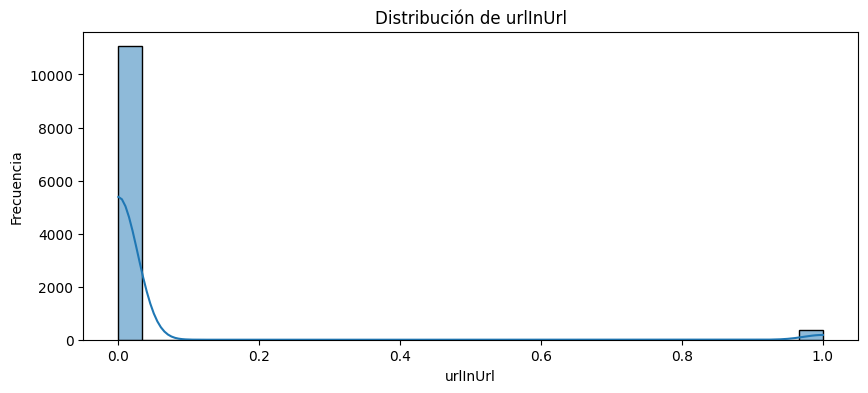

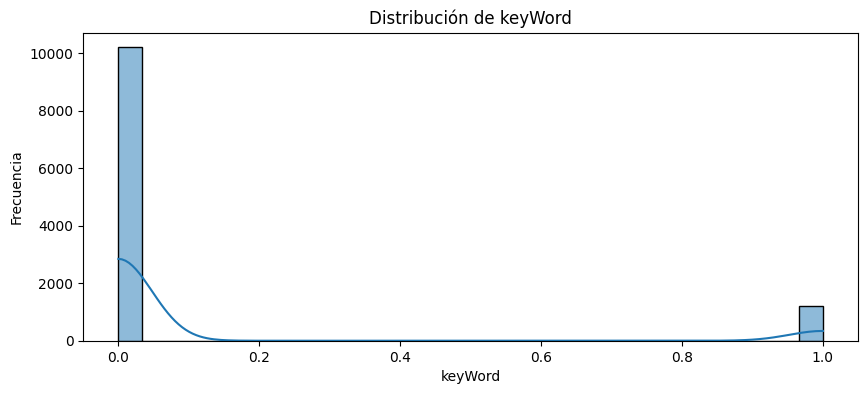

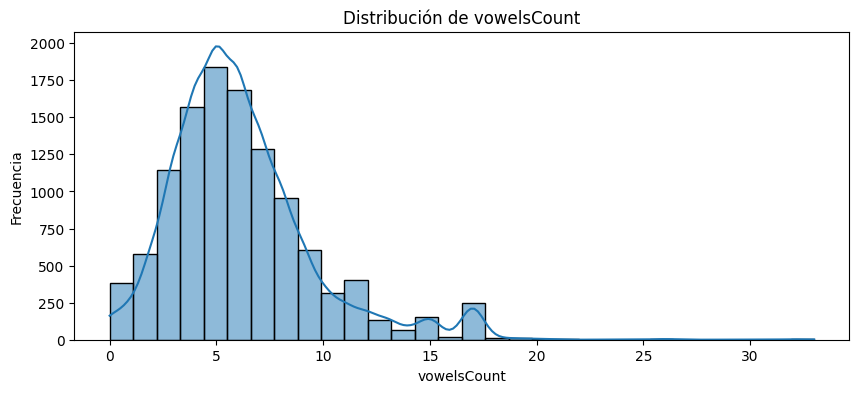

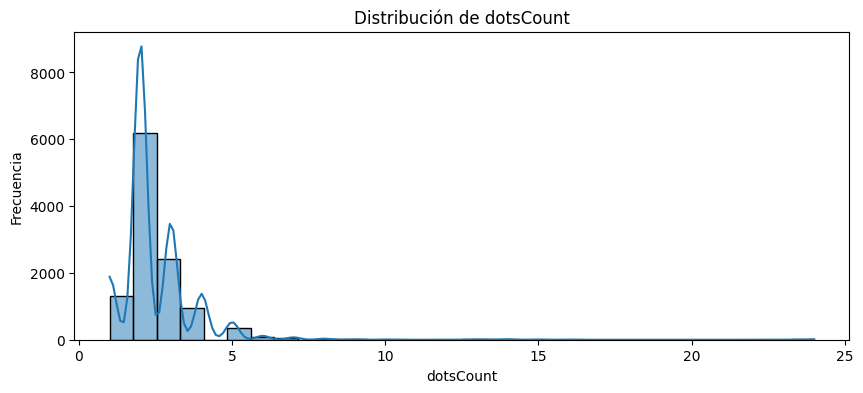

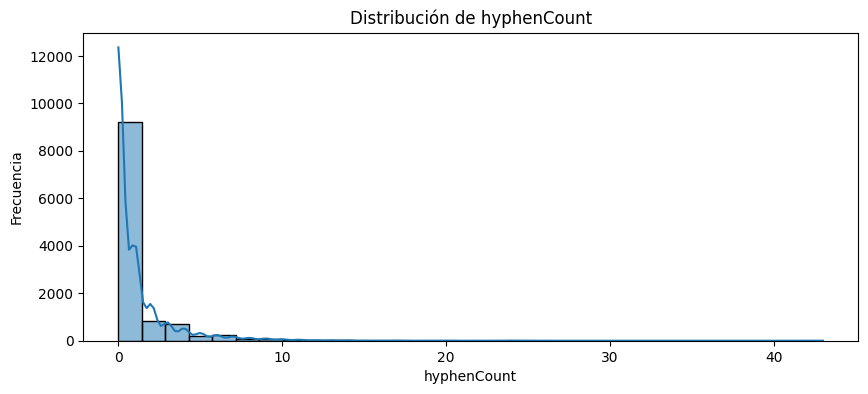

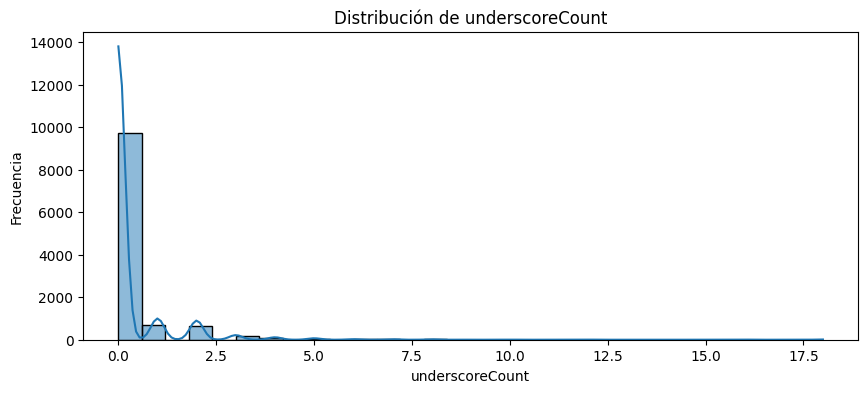

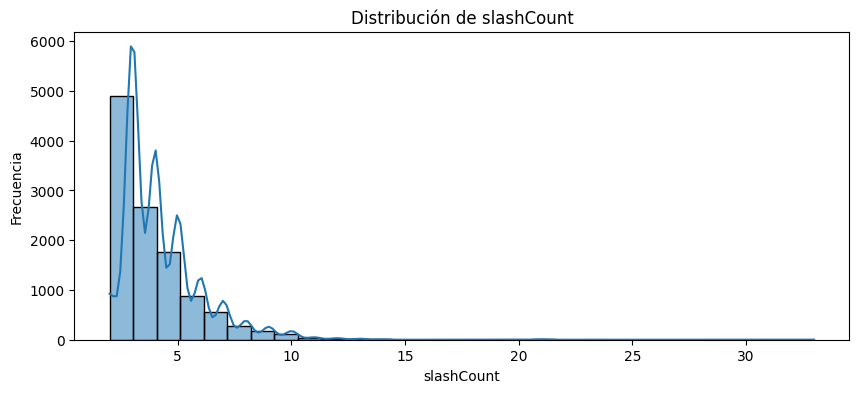

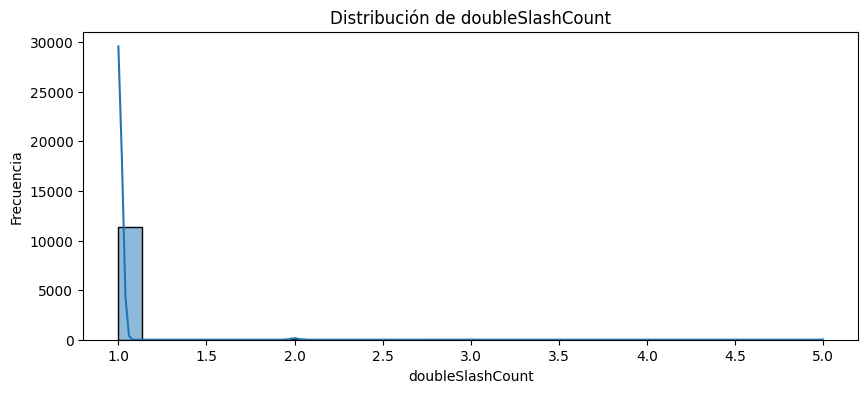

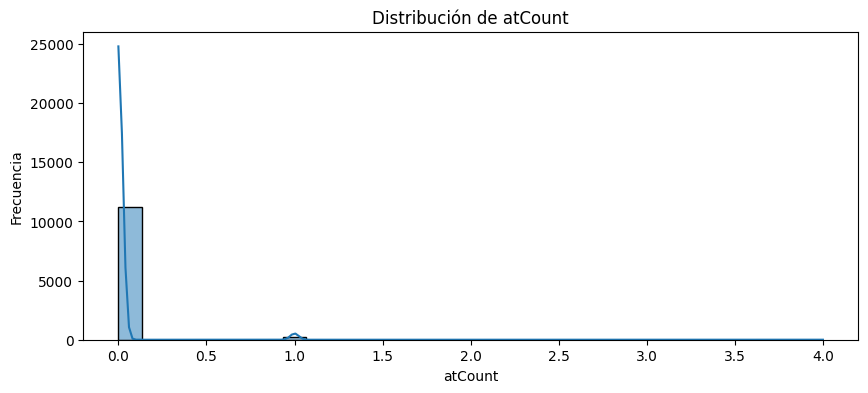

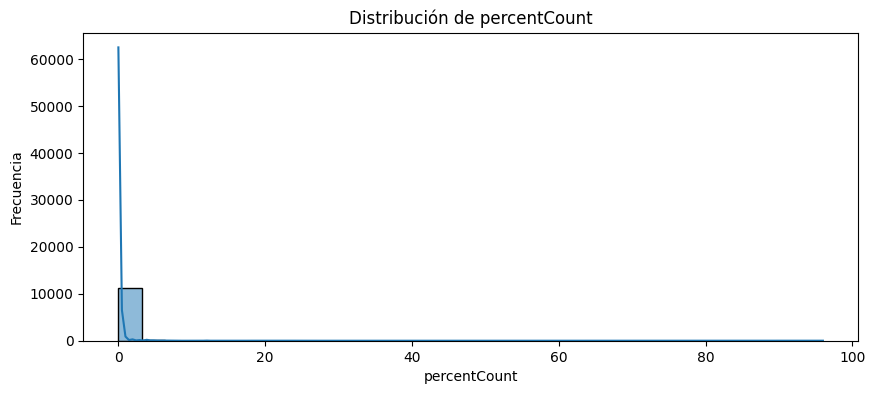

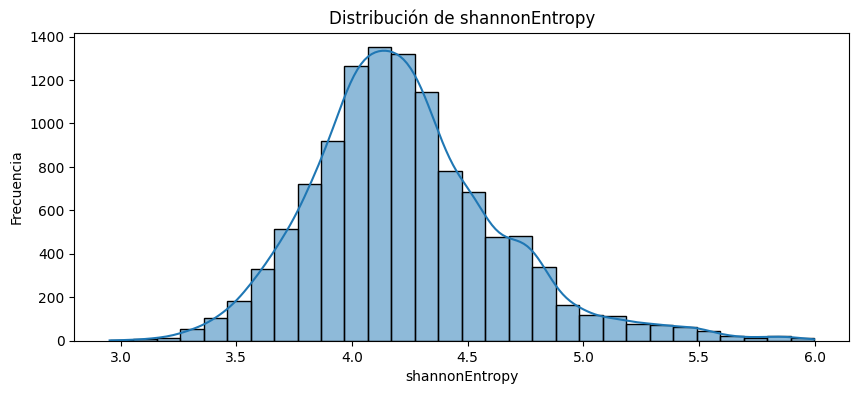

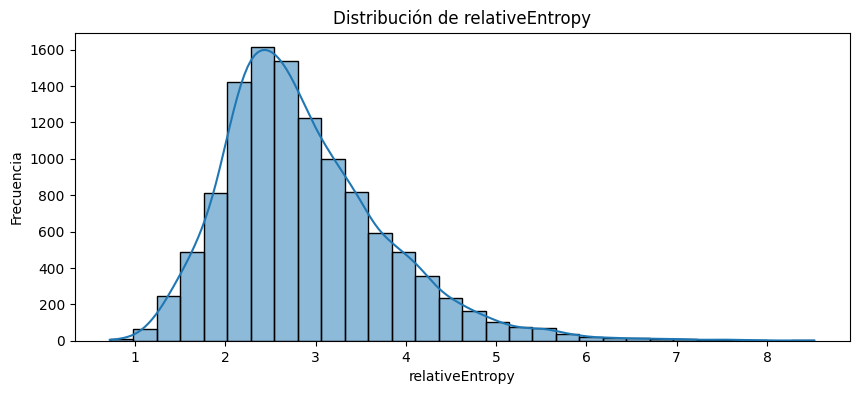

In [112]:
for columna in columnasNumericas:
    plt.figure(figsize=(10, 4))
    sns.histplot(finalDf[columna], kde=True, bins=30)
    plt.title(f'Distribución de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')
    plt.show()

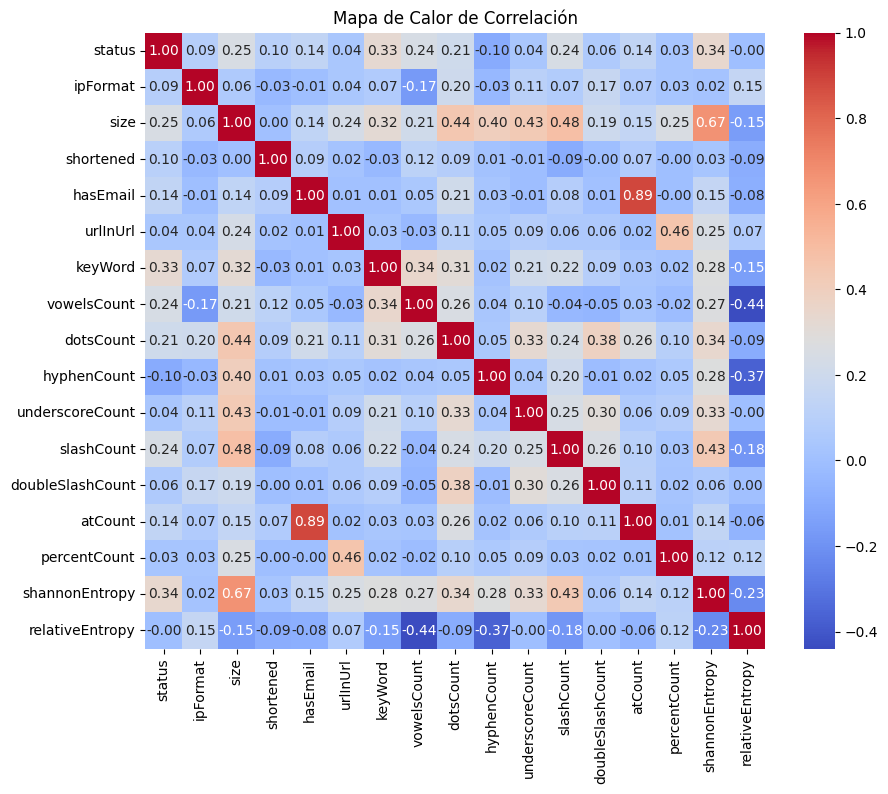

In [113]:
correlacion = finalDf.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Mapa de Calor de Correlación')
plt.show()

In [117]:
toNormalize = [
    'size',
    'vowelsCount',
    'dotsCount',
    'hyphenCount',
    'underscoreCount',
    'slashCount',
    'doubleSlashCount',
    'atCount',
    'percentCount',
    'shannonEntropy',
    'relativeEntropy'
]

scaler = StandardScaler()
finalDf[toNormalize] = scaler.fit_transform(finalDf[toNormalize])

In [123]:
X = finalDf.drop(['url', 'status', 'domain'], axis=1)
y = finalDf['status']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=101,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.214,
    random_state=101,
    stratify=y_temp
)


## Implementación